In [8]:
# Stations
# Runs
import os
import pandas as pd
import numpy as np
from stompy import utils
import six
import matplotlib.gridspec as gridspec
from stompy import filters
import matplotlib.pyplot as plt
%matplotlib notebook

from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver

In [14]:
# /opt/sfb_ocean/suntans/runs/merge_005-20170610avg:
#    This showed a 2m/10days increase in fs.  run had fluxes calculated without the 
#    eta offset
# /opt/sfb_ocean/suntans/runs/merge_005-20170610-fixOffset/
modelA=sun_driver.SuntansModel.load("/opt/sfb_ocean/suntans/runs/merge_005-20170610avg-retry/")
modelA.projection="EPSG:26910"

INFO:DFlowModel:Will read cell depths, too
INFO:DFlowModel:Will read edge depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [3]:
modelB=sun_driver.SuntansModel.load("/opt/sfb_ocean/suntans/runs/merge_005-20170610-fixOffset/")
modelB.projection="EPSG:26910"

INFO:DFlowModel:Will read cell depths, too
INFO:DFlowModel:Will read edge depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [21]:
modelC=sun_driver.SuntansModel.load("/opt/sfb_ocean/suntans/runs/merge_006-20170610/")
modelC.projection="EPSG:26910"

INFO:DFlowModel:Will read cell depths, too
INFO:DFlowModel:Will read edge depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [22]:
modelD=sun_driver.SuntansModel.load("/opt/sfb_ocean/suntans/runs/merge_006-20170610-recompile/")
modelD.projection="EPSG:26910"

INFO:DFlowModel:Will read cell depths, too
INFO:DFlowModel:Will read edge depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [36]:
modelD2=sun_driver.SuntansModel.load("/opt/sfb_ocean/suntans/runs/merge_006-20170620-recompile/")
modelD2.projection="EPSG:26910"

INFO:DFlowModel:Will read cell depths, too
INFO:UnstructuredGrid:Will flip 0 edges


In [23]:
cache_dir="cache"
os.path.exists(cache_dir) or os.makedirs(cache_dir)

True

In [37]:
start=modelD.run_start
end  =modelD2.run_stop

def noaa_water_level(station,start,stop,**kw):
    ds=noaa_coops.coops_dataset_product(station=station,product='water_level',
                                        start_date=start,end_date=stop,
                                        cache_dir=cache_dir)
    ds=ds.set_coords(['lon','lat'])
    da=ds.water_level.isel(station=0)
    da.attrs.update(kw)
    return da
alameda_wl=noaa_water_level(9414750,start,end,name="NOAA Alameda")
alameda_wl

INFO:noaa_coops:Fetching 2017-06-10 00:00:00 -- 2017-06-30 00:00:00


<xarray.DataArray 'water_level' (time: 4801)>
array([1.037, 1.014, 0.992, ..., 1.688, 1.708, 1.73 ])
Coordinates:
    station  <U7 '9414750'
    lat      float64 37.77
    lon      float64 -122.3
  * time     (time) datetime64[ns] 2017-06-10 2017-06-10T00:06:00 ... 2017-06-30
Attributes:
    datum:    NAVD
    name:     NOAA Alameda

In [38]:
#models=[modelA,modelB,modelC,modelD]
models=[modelD,modelD2]
observations=[alameda_wl]

if len(models)==1:
    model_labels=["Model"]
else:
    model_labels=[ os.path.basename(model.run_dir) for model in models]
    
# Extract relevant variable and location from model

base_obs=observations[0] # defines the variable and location for extracting model data
model_data=[] # a data array per model
for model in models:
    ds=model.extract_station(ll=[base_obs.lon,base_obs.lat])
    if base_obs.name=='water_level':
        da=ds['eta']
        da.name='water_level' # having the same name helps later
    else:
        raise Exception("Not yet ready")
    model_data.append(da)

# For many plots and metrics need a common timeline -- 
# Get them on common time frames
resampled=[]

def resample_and_add(da,suffix):
    df=da.to_dataframe().resample('15T').mean()
    for col in df.columns:
        df.rename({col:col+suffix},inplace=True,axis=1)
    resampled.append(df)
    return da.name+suffix

model_columns=[]
obs_columns=[]

for i,da in enumerate(model_data):
    col=resample_and_add(da,"_mod%d"%i)
    model_columns.append(col)
    
for i,da in enumerate(observations):
    col=resample_and_add(da,"_obs%d"%i)    
    obs_columns.append(col) 

combined=resampled[0]
for df in resampled[1:]:
    combined=pd.merge(combined,df,left_index=True,right_index=True)
    

<IPython.core.display.Javascript object>


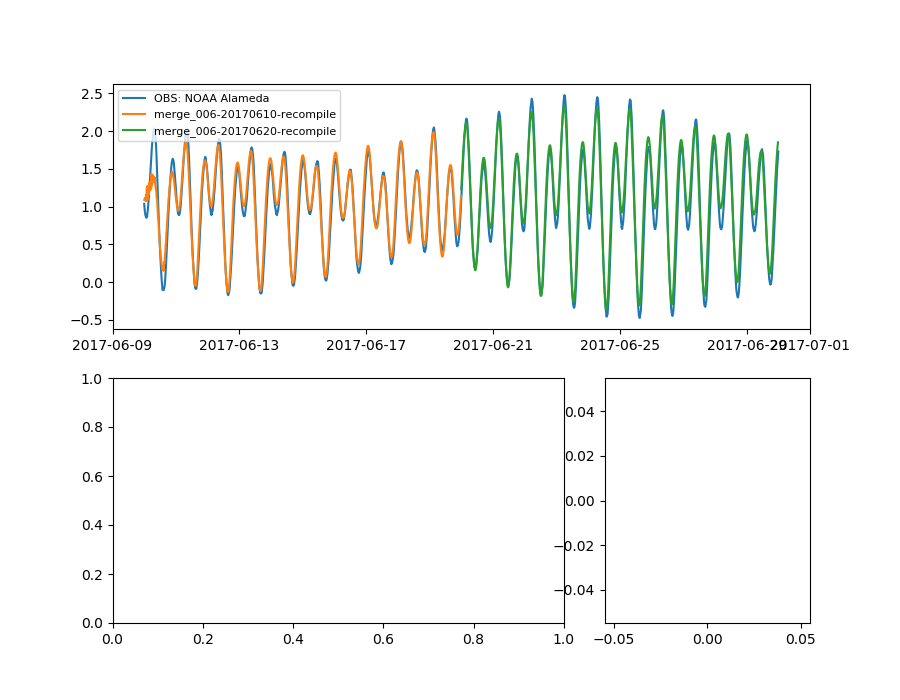

ValueError: math domain error

In [39]:
gs = gridspec.GridSpec(2, 3)
fig=plt.figure(figsize=(9,7))
ts_ax = fig.add_subplot(gs[0, :])
lp_ax = fig.add_subplot(gs[1, :-1])
scat_ax=fig.add_subplot(gs[1, -1])

offset_mode='obs' # Adjust means to match observation mean

obs_mean=np.nanmean(observations[0].values)
model_mean=np.mean(model_data[0].values)

if offset_mode=='model':
    obs_offset=obs_mean-model_mean
else:
    obs_offset=0.0
if offset_mode=='obs':
    mod_offset=model_mean-obs_mean
else:
    mod_offset=0.0

if 1: # Tidal time scale plot:
    ax=ts_ax

    for obs in observations:
        ax.plot(obs.time,obs.values-obs_offset,label="OBS: %s"%obs.attrs['name'])
    for mod,mod_label in zip(model_data,model_labels):
        ax.plot(mod.time,mod.values-mod_offset,label=mod_label)
    ax.legend(fontsize=8)

# Scatter:
if 1:
    ax=scat_ax
    ax.plot(combined[obs_columns[0]],combined[model_columns[0]],'b.',ms=2)
    
# Lowpass:
if 1:
    ax=lp_ax
    t=combined.index.values
    lp_samples=36*4
    for obs_col in obs_columns:
        ax.plot(t,
                filters.lowpass_fir(combined[obs_col],lp_samples)-obs_offset,
                label='OBS')
    for mod_col,mod_label in zip(model_columns,model_labels):
        ax.plot(t, 
                filters.lowpass_fir(combined[mod_col],lp_samples)-mod_offset,
                label=mod_label)
    ax.legend(fontsize=8)
    
ts_ax.set_title(model.run_dir)
None

<IPython.core.display.Javascript object>


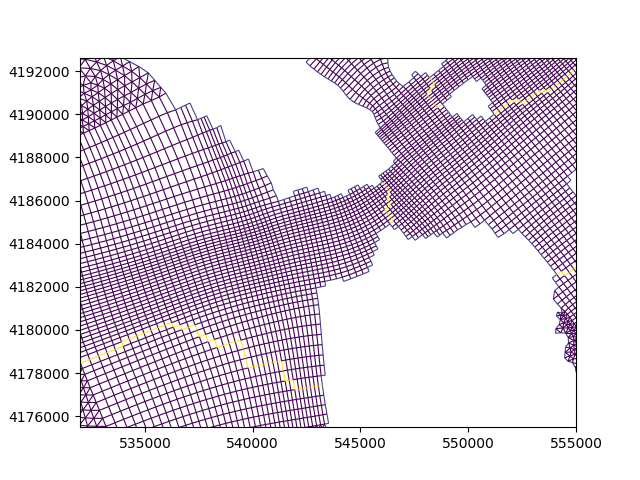

In [35]:
import xarray as xr 
from stompy.grid import unstructured_grid
avgds=xr.open_dataset(modelA.avg_outputs()[0])
g=unstructured_grid.UnstructuredGrid.from_ugrid(avgds)
plt.figure()
g.plot_edges(values=avgds.mark.values)

In [34]:
avgds

<xarray.Dataset>
Dimensions:       (Nc: 57719, Ne: 108448, Nk: 50, Nkw: 51, Np: 50711, Two: 2, numsides: 6, time: 480)
Coordinates:
    xv            (Nc) float64 5.809e+05 5.827e+05 ... 5.295e+05 5.298e+05
    yv            (Nc) float64 4.151e+06 4.152e+06 ... 4.176e+06 4.176e+06
    xe            (Ne) float64 ...
    ye            (Ne) float64 ...
    z_r           (Nk) float64 ...
    z_w           (Nkw) float64 ...
    Nk            (Nc) int32 ...
  * time          (time) datetime64[ns] 2017-06-10 ... 2017-06-19T23:30:00
Dimensions without coordinates: Nc, Ne, Nkw, Np, Two, numsides
Data variables:
    suntans_mesh  int32 ...
    cells         (Nc, numsides) int32 0 11345 358 ... 999999 999999 999999
    nfaces        (Nc) int32 ...
    face          (Nc, numsides) int32 ...
    edges         (Ne, Two) int32 5057 5058 5053 5057 ... 50664 50705 50664
    neigh         (Nc, numsides) int32 ...
    grad          (Ne, Two) int32 ...
    xp            (Np) float64 5.809e+05 5.825e+05 ..